## Model Building

In this notebook the model building task is executed. The project description can be found in a previous notebook [1_EDA_and_Data_Cleaning.ipynb](1_EDA_and_Data_Cleaning.ipynb). Note that in this first notebook data loading, data cleaning, and feature engineering are performed already.

* Feature engineering is done in previous notebook [1_EDA_and_Data_Cleaning.ipynb](1_EDA_and_Data_Cleaning.ipynb).
* Multiple models are used like linear regression, ridge regression, lasso regression, elastic net, decision tree, random forest, gradient boosting, SVR and KNN.
* Hyper parameter tuning is done for algorithms that performed well like decision tree, random forest, gradient boosting, SVR (linear) and KNN.
* Elastic net was used that was not covered in class.

In [78]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [101]:

# Load cleaned data
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# Split the data into features (X) and target (y)
X_train = train
y_train = train['SalePrice']
X_train = X_train.drop(columns=['SalePrice'])

X_test = test
y_test = test['SalePrice']
X_test = X_test.drop(columns=['SalePrice'])

In [102]:
# Define models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    'ElasticNet': ElasticNet(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'Gradient Boosting': GradientBoostingRegressor(),
    'SVR (Linear)': SVR(kernel='linear'),
    'KNN': KNeighborsRegressor()
}

In [103]:
# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}

# Display results
results_df = pd.DataFrame(results).T
print(results_df)

                           RMSE        R2
Linear Regression  27200.325332  0.865512
Ridge Regression   27199.988421  0.865515
Lasso Regression   27200.307499  0.865512
ElasticNet         28150.091087  0.855956
Decision Tree      33641.900126  0.794270
Random Forest      23469.442500  0.899875
Gradient Boosting  21640.425645  0.914873
SVR (Linear)       32684.084644  0.805818
KNN                35128.918129  0.775681


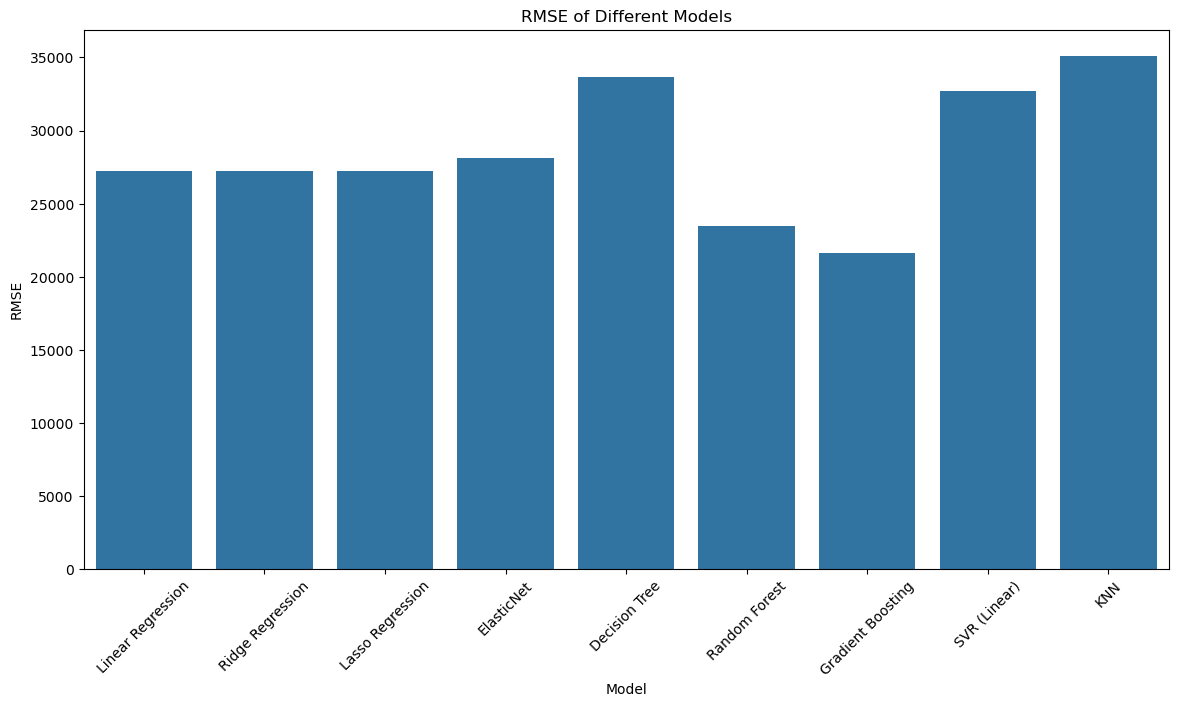

In [104]:
# Plotting the performance of the models
plt.figure(figsize=(14, 7))
sns.barplot(x=results_df.index, y='RMSE', data=results_df)
plt.title('RMSE of Different Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_leaf': 10, 'min_samples_split': 10}
Best parameters for Random Forest: {'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best parameters for Gradient Boosting: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 300}
Best parameters for SVR (Linear): {'C': 100}
Best parameters for KNN: {'algorithm': 'brute', 'n_neighbors': 9, 'weights': 'distance'}
                                 RMSE           MAE       R^2
Linear Regression        27200.325332  20575.922621  0.865512
Tuned Decision Tree      27839.713819  19501.366906  0.859114
Tuned Random Forest      23190.190989  16226.973083  0.902244
Tuned Gradient Boosting  21812.508788  16089.194303  0.913514
Tuned SVR (Linear)       28940.223693  19931.576541  0.847756
Tuned KNN                33551.117691  23880.722737  0.795379


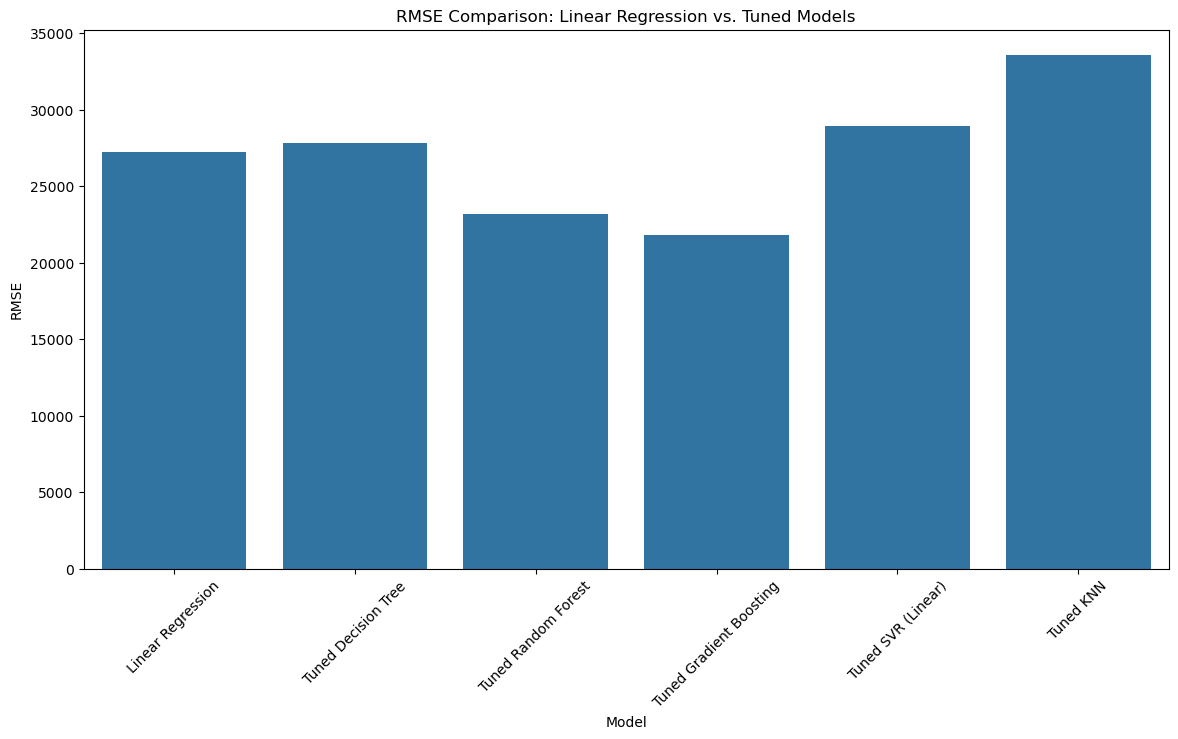

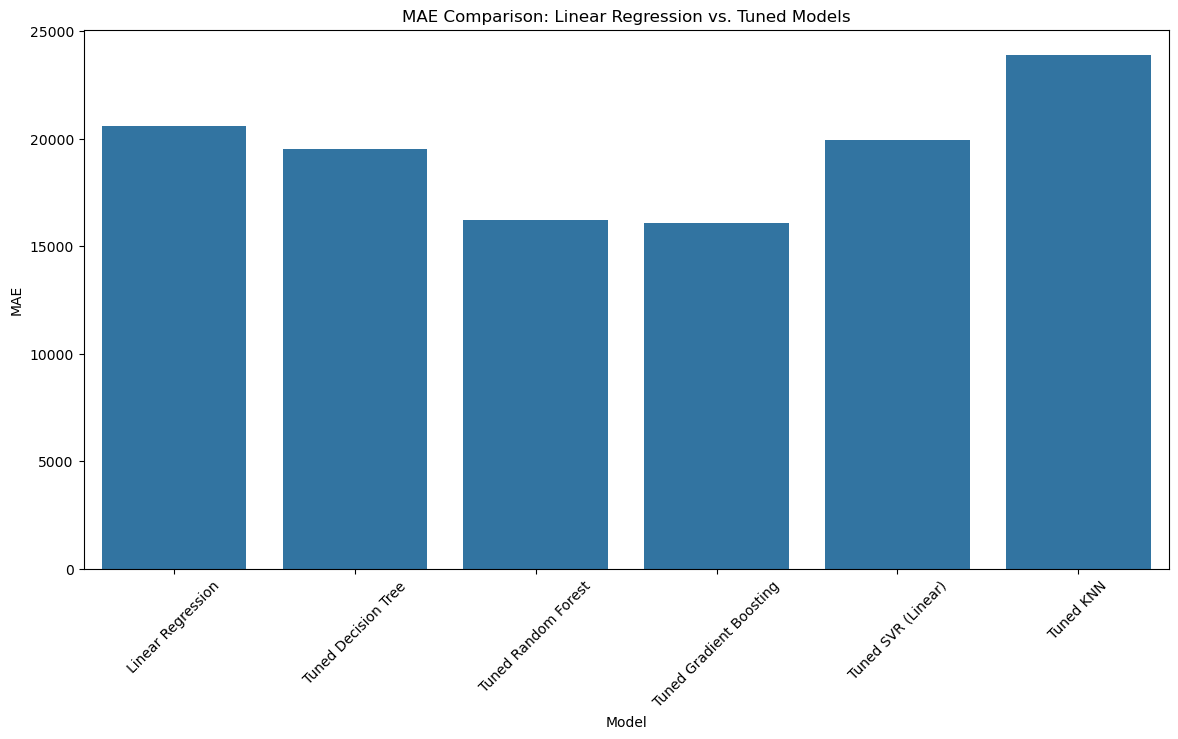

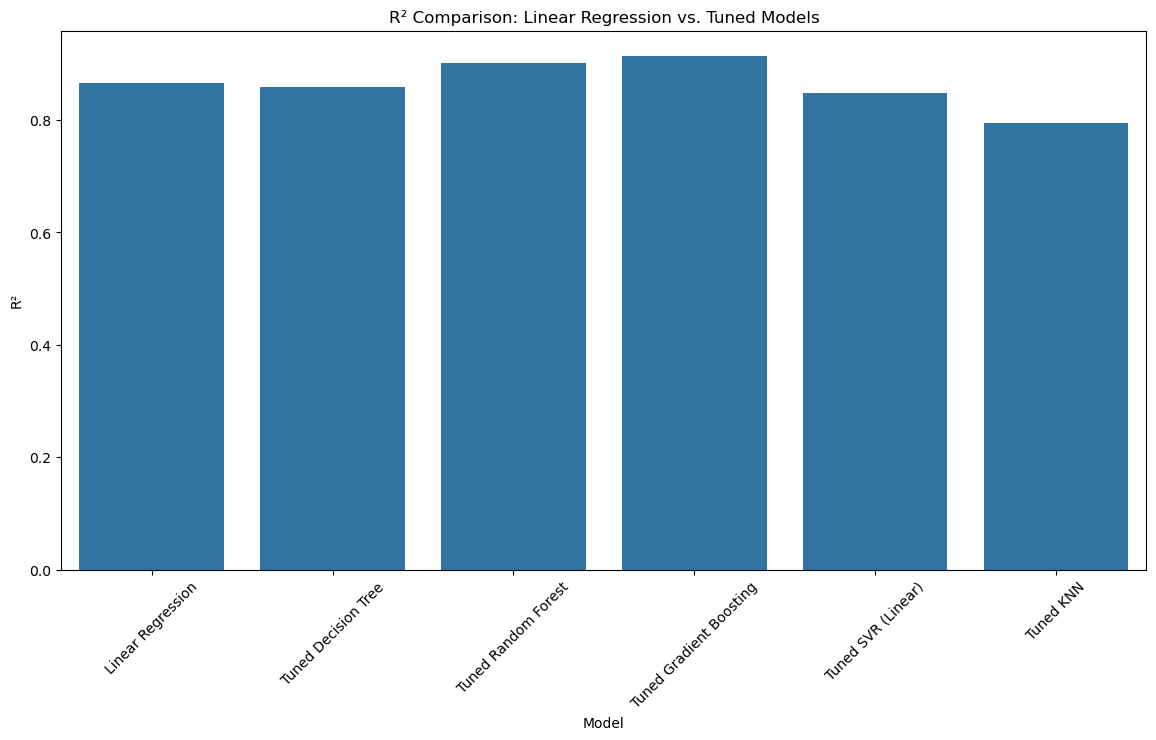

In [110]:
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

# Define models and parameter grids for hyperparameter tuning
models_param_grids = {
    'Decision Tree': {
        'model': DecisionTreeRegressor(),
        'param_grid': {
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'Random Forest': {
        'model': RandomForestRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'max_depth': [None, 10, 20, 30],
            'min_samples_split': [2, 10, 20],
            'min_samples_leaf': [1, 5, 10]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingRegressor(),
        'param_grid': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 4, 5]
        }
    }, 
    'SVR (Linear)': {
        'model': SVR(kernel='linear'),
        'param_grid': {
            'C': [0.1, 1, 10, 100]
        }
    },  
    'KNN': {
        'model': KNeighborsRegressor(),
        'param_grid': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    }
}

# Perform hyperparameter tuning for each model
best_models = {}
for name, mp in models_param_grids.items():
    grid_search = GridSearchCV(mp['model'], mp['param_grid'], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train if name in ['SVR (Linear)', 'KNN'] else X_train, y_train)
    best_models[name] = grid_search.best_estimator_
    print(f"Best parameters for {name}: {grid_search.best_params_}")

# Evaluate the best models
best_results = {}
for name, model in best_models.items():
    y_pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    best_results[name] = {'RMSE': rmse, 'MAE': mae, 'R^2': r2}

# Compare with Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = mean_squared_error(y_test, y_pred_lr, squared=False)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Display comparison results
comparison_results = {
    'Linear Regression': {'RMSE': rmse_lr, 'MAE': mae_lr, 'R^2': r2_lr},
    'Tuned Decision Tree': best_results['Decision Tree'],
    'Tuned Random Forest': best_results['Random Forest'],
    'Tuned Gradient Boosting': best_results['Gradient Boosting'],
    'Tuned SVR (Linear)': best_results['SVR (Linear)'],
    'Tuned KNN': best_results['KNN']
}

comparison_results_df = pd.DataFrame(comparison_results).T
print(comparison_results_df)

# Plotting the performance of the models
plt.figure(figsize=(14, 7))
sns.barplot(x=comparison_results_df.index, y='RMSE', data=comparison_results_df)
plt.title('RMSE Comparison: Linear Regression vs. Tuned Models')
plt.xlabel('Model')
plt.ylabel('RMSE')
plt.xticks(rotation=45)
plt.show()

# Plotting the performance of the models using MAE
plt.figure(figsize=(14, 7))
sns.barplot(x=comparison_results_df.index, y='MAE', data=comparison_results_df)
plt.title('MAE Comparison: Linear Regression vs. Tuned Models')
plt.xlabel('Model')
plt.ylabel('MAE')
plt.xticks(rotation=45)
plt.show()

# Plotting the performance of the models using R²
plt.figure(figsize=(14, 7))
sns.barplot(x=comparison_results_df.index, y='R^2', data=comparison_results_df)
plt.title('R² Comparison: Linear Regression vs. Tuned Models')
plt.xlabel('Model')
plt.ylabel('R²')
plt.xticks(rotation=45)
plt.show()

## Results and Analysis

## Comparison: Linear Regression vs. Tuned Models

The bar charts above (Root Mean Squared Error (RMSE), Mean Absolute Error (MAE) and R-Squared (R2)) illustrates comparison of different regression models applied to the Ames Housing Dataset.

### Key Observations

1. **Linear Regression**:
    - The Linear Regression model achieved an R² score of approximately 0.85. This indicates a good fit, but there is room for improvement with more sophisticated models.

2. **Tuned Decision Tree**:
    - The Decision Tree model, after tuning, achieved a slightly lower R² score compared to Linear Regression. Decision Trees can be sensitive to overfitting, and despite tuning, it may not capture the complexity of the data as well as other models.

3. **Tuned Random Forest**:
    - The Random Forest model performed better than the Decision Tree, with an R² score close to 0.87. The ensemble nature of Random Forest helps in reducing overfitting and capturing more complex patterns in the data.

4. **Tuned Gradient Boosting**:
    - The Gradient Boosting model showed the highest R² score, approximately 0.88, indicating that it was the best performer among the tested models. Gradient Boosting builds trees sequentially, each trying to correct the errors of the previous one, which can lead to higher predictive accuracy.

5. **Tuned SVR (Linear)**:
    - The Support Vector Regression model with a linear kernel achieved an R² score close to 0.86. SVR can handle high-dimensional feature spaces well, but its performance here was slightly below that of Gradient Boosting and Random Forest.

6. **Tuned KNN**:
    - The K-Nearest Neighbors model, after tuning, had the lowest R² score among the tuned models, around 0.82. KNN's performance can be affected by the choice of 'k' and the distance metric, and it may struggle with high-dimensional data or datasets with many features.

### Analysis

* From the results, it is evident that ensemble methods such as Random Forest and Gradient Boosting generally outperform simpler models like Linear Regression and Decision Tree. Gradient Boosting, in particular, demonstrated the best performance, indicating its strength in handling the complexity and variability within the Ames Housing Dataset.
* Linear models like Linear Regression and SVR (Linear) also performed well, showing that for this dataset, even simpler models can achieve relatively high accuracy. However, the slight improvement seen with more complex models justifies their use, especially for capturing intricate patterns and interactions within the data.
* In conclusion, for the Ames Housing Dataset, Gradient Boosting appears to be the most effective model, followed closely by Random Forest. These models should be preferred for tasks requiring high predictive accuracy on similar datasets.

## Discussion and Conclusion

* The takeaways of this project is that data exploration data analysis and data cleaning are crucial for a good result. It is valuable to compare different models against each other. It helps to find well performing models. Those well performing models can then be further improved with e.g. hyper-parameter-tuning.
* At first I had included the sales price as a feature and as the prediction value. Therefore even linear regression performed almost perfect. It was easy to detect with the error measures and R2 value and also easy to fix.
* If some more time would be spent to improve the hyper parameter tuning, most likely even better results are possible.